# Chess ELO Estimator

In this notebook we will build the neural network which would estimate the ELO rating of a player based on the games played against various opponents. As usual, we will start by first including the necessary libraries for work.

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn import preprocessing

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [4]:
np.random.seed(25)
torch.manual_seed(25)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(25)

In [6]:
def get_device():
    if torch.cuda.is_available():
        d = 'cuda'
    else:
        d = 'cpu'
    return torch.device(d)


def bind_gpu(data):
    d = get_device()
    if isinstance(data, (list, tuple)):
        return [bind_gpu(data_elem) for data_elem in data]
    return data.to(d, non_blocking=True)

## Uploading data

In the last notebook we have prepared the data and wrote it into the file "ChessData.aca". We are going to use this data for our work.

There has been one thing left to address. For our model we will consider a player with at least 10 games played, and will consider the first 10 games that player has played. The rating of a player changes with every game played, therefore it was not the same before playing certain amount of games as well as it will change after the next game is finished, hence, the number of games considered should be as small as possible. On the other hand, in order for our model to be successful, we need a substantial number of games played in order for our model to give meaningful results. Therefore, a compromise should be made, hence, we consider the first 10 games played.

An interested reader can reduce or increase the number of games played and compare the results.

In [11]:
with open('ChessData.aca','rb') as f:
    player_count = pickle.load(f)
    player_names = pickle.load(f)
    player_ids = pickle.load(f)
    matches = pickle.load(f)
    elos = pickle.load(f)

In [13]:
game_limit = 10

x = []
y = []

for i in range(player_count):
    if len(matches[i]) >= game_limit:
        element = [matches[i][j][1]*10000 + matches[i][j][0] for j in range(game_limit)]
        x.append(element)
        y.append(elos[i])

## Preprocessing data

In [16]:
x = np.array(x)
y = np.array(y)

x_train_valid, x_test, y_train_valid, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=25)
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train_valid, y_train_valid, test_size=0.1, random_state=25)

print('x_train size: ', x_train.shape)
print('y_train size: ', y_train.size)
print('x_valid size: ', x_valid.shape)
print('y_valid size: ', y_valid.size)
print('x_test size: ', x_test.shape)
print('y_test size: ', y_test.size)

x_train size:  (20745, 10)
y_train size:  20745
x_valid size:  (2305, 10)
y_valid size:  2305
x_test size:  (5763, 10)
y_test size:  5763


In [18]:
scaler = preprocessing.StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

In [20]:
x_train, y_train = torch.FloatTensor(x_train), torch.FloatTensor(y_train)
train_data = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

x_valid, y_valid = torch.FloatTensor(x_valid), torch.FloatTensor(y_valid)
valid_data = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

x_test, y_test = torch.FloatTensor(x_test), torch.FloatTensor(y_test)
test_data = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

## Creation of the Neural Network

The input of our Neural Network will be a vector of size `game_limit`. We will use `ReLu` as activation function.

In [23]:
number_of_features = game_limit
output_size = 1

In [25]:
class EloEstimator(nn.Module):
    def __init__(self, number_of_features, output_size):
        super(EloEstimator, self).__init__()
        layers = [
            nn.Linear(number_of_features, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, games_played):
        return self.model(games_played)

## Training the Network

As the loss function we will be using the mean absolute error function.

In [28]:
device = get_device()
model = EloEstimator(number_of_features, output_size)
model.to(device)

number_of_epochs = 15

optimizer = Adam(params= model.parameters())
train_mae_by_epochs = []
valid_mae_by_epochs = []

for epoch in range(number_of_epochs):
    epoch_train_mae, train_samples = 0, 0
    epoch_valid_mae, valid_samples = 0, 0

    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        optimizer.zero_grad()

        predictions = model(inputs).squeeze()
        mae = (predictions - labels).abs().mean()

        mae.backward()
        optimizer.step()

        epoch_train_mae += mae.item() * batch_size
        train_samples += batch_size

    model.eval()
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = inputs.size(0)

            predictions = model(inputs).squeeze()
            mae = (predictions - labels).abs().mean()

            epoch_valid_mae += mae.item() * batch_size
            valid_samples += batch_size

    avg_train_mae = epoch_train_mae / train_samples
    avg_valid_mae = epoch_valid_mae / valid_samples

    train_mae_by_epochs.append(avg_train_mae)
    valid_mae_by_epochs.append(avg_valid_mae)

Now, we can display and visualize the loss function on training and validation set.

In [31]:
for epoch in range(number_of_epochs):
    print(f"Epoch [{epoch + 1}/{number_of_epochs}], Train mae: {train_mae_by_epochs[epoch]:.4f}")

for epoch in range(number_of_epochs):
    print(f"Epoch [{epoch + 1}/{number_of_epochs}], Valid mae: {valid_mae_by_epochs[epoch]:.4f}")

Epoch [1/15], Train mae: 1627.8165
Epoch [2/15], Train mae: 1346.4004
Epoch [3/15], Train mae: 832.0463
Epoch [4/15], Train mae: 367.9208
Epoch [5/15], Train mae: 274.6239
Epoch [6/15], Train mae: 270.4755
Epoch [7/15], Train mae: 269.1957
Epoch [8/15], Train mae: 268.3173
Epoch [9/15], Train mae: 267.6174
Epoch [10/15], Train mae: 266.9996
Epoch [11/15], Train mae: 266.5814
Epoch [12/15], Train mae: 266.1420
Epoch [13/15], Train mae: 265.8460
Epoch [14/15], Train mae: 265.5733
Epoch [15/15], Train mae: 265.3676
Epoch [1/15], Valid mae: 1541.9323
Epoch [2/15], Valid mae: 1131.5122
Epoch [3/15], Valid mae: 549.0655
Epoch [4/15], Valid mae: 286.6407
Epoch [5/15], Valid mae: 270.7394
Epoch [6/15], Valid mae: 268.8930
Epoch [7/15], Valid mae: 267.3877
Epoch [8/15], Valid mae: 266.9384
Epoch [9/15], Valid mae: 266.0698
Epoch [10/15], Valid mae: 265.6412
Epoch [11/15], Valid mae: 264.8877
Epoch [12/15], Valid mae: 264.8098
Epoch [13/15], Valid mae: 264.4045
Epoch [14/15], Valid mae: 264.0860

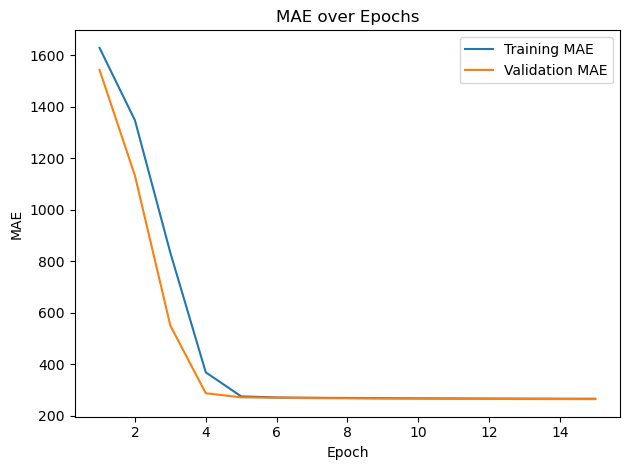

In [33]:
plt.plot(np.arange(1,number_of_epochs+1), train_mae_by_epochs, label='Training MAE')
plt.plot(np.arange(1,number_of_epochs+1), valid_mae_by_epochs, label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluation of the Network

In [36]:
test_mse = 0
test_mae = 0
test_samples = 0

model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        predictions = model(inputs).squeeze()
        mae = (predictions - labels).abs().mean()

        test_mae += mae.item() * batch_size
        test_samples += batch_size
        
test_mae /= test_samples
print(f"Test mae: {test_mae:.4f}")

Test mae: 267.1726


Let us see what is the average ELO rating of all the players considered.

In [39]:
total_rtg = 0
num_of_players = 0

for i in range(player_count):
    if len(matches[i]) >= game_limit:
        total_rtg += elos[i]
        num_of_players += 1

print(f"Average ELO rating of players considered: {total_rtg/num_of_players:.4f}")

Average ELO rating of players considered: 1675.5060


## Conclusion

As evident from the results, the mean absolute error is relatively high compared to the average rating of a player. That being said, the model does not give a precise estimation, but can still be usefull when determining a tier in which a player should be placed.